# 18.335 pset 1 solutions

## Problem 2: Floating point

As explained in the solutions, the smallest non-representable integer [Trefethen problem 13.2(c)] in IEEE double precision should be $2^{53}+1$.  Let's check $2^{53} + o$ for $o \in {-3,-2,...,3}$, by the simple expedient of comparing to integers (using a 64-bit integer type, `Int64`, such that these integers are represented exactly; note that `Int64` is the default integer type in Julia except on 32-bit systems):

In [1]:
β = Int64(2)  # make sure we are using 64-bit ints, even on 32-bit machines
p = 53
for o in -3:3
    i = β^p + o
    println("β^p + $o = $i exactly represented in Float64? ", i == Float64(i))
end

β^p + -3 = 9007199254740989 exactly represented in Float64? true
β^p + -2 = 9007199254740990 exactly represented in Float64? true
β^p + -1 = 9007199254740991 exactly represented in Float64? true
β^p + 0 = 9007199254740992 exactly represented in Float64? true
β^p + 1 = 9007199254740993 exactly represented in Float64? false
β^p + 2 = 9007199254740994 exactly represented in Float64? true
β^p + 3 = 9007199254740995 exactly represented in Float64? false


Notice that $2^{53}+2$ is exactly represented, because that is equal to $(2^{52}+1) \times 2$.

Above, we are relying on the fact that Julia's `==` operation is exact for comparing `Float64` to `Int64`, and it didn't do something approximate like round the `Int64` to `Float64` first ([it doesn't, fortunately](https://github.com/JuliaLang/julia/blob/3ff44eab64c554b31a87df1b972e99959ad15e54/base/float.jl#L420-L427)).   How can we check using **only floating-point operations?**  Pretty easily:

In [2]:
2.0^53 - 1 == 2.0^53 # both 2^53 and 2^53 - 1 are distinct in 𝔽

false

In [3]:
(2.0^53 - 1) - 1 == 2.0^53 - 1 # still distinct

false

In [4]:
2.0^53 + 1 == 2.0^53 # 2^53 + 1 gets rounded back to 2^53 in 𝔽

true

## Problem 3: Funny functions

### part (a)

Consider the following naive function to compute the $L_4$ norm $(|x|^4 + |y|^4))^{1/4}$ of $(x,y)$:

In [5]:
L4(x,y) = (abs(x)^4 + abs(y)^4)^(1/4)

L4 (generic function with 1 method)

We should have `L4(x,0)` give $|x|$, but for very small or very large `x` we get floating-point **underflow** or **overflow**, respectively.  In the default double precision (`Float64`):

In [6]:
L4(1e-100, 0)  # (1e-100)⁴ underflows to 0.0

0.0

In [7]:
L4(1e+100, 0)  # (1e+100)⁴ overflows to Inf

Inf

To eliminate this problem, we can simply compute $s = \max\{|x|,|y|\}$ and then pull out this scale factor, since in exact arithmetic $L_4(x,y) = s L_4(x/s,y/s)$ for any $s > 0$.  In this way, we avoid underflow/overflow in the leading-order term.  (If $|y|\ll |x|$ and $|y/x|^4$ underflows to zero, we don't care, because $1 \oplus |y/x|^4$ will round to `1.0` long before that point.)

In [8]:
function L4good(x,y)
    ax, ay = abs(x), abs(y)
    s = max(ax,ay)
    if s == 0
        return float(s) # don't divide by zero if x==y==0
    else
        return s * ((ax/s)^4 + (ay/s)^4)^(1/4)
    end
end
    

L4good (generic function with 1 method)

In [9]:
L4good(1e-100, 0)

1.0e-100

In [10]:
L4good(1e+100, 0)

1.0e100

In [11]:
L4good(0, 0)

0.0

Let's compute the maximum relative error (compared to `BigFloat`) for million random numbers with random magnitudes from $10^{-308}$ to $10^{+308}$:

In [12]:
maxerr = 0.0
for i = 1:10^6
    x = (rand() - 0.5) * 10.0^rand(-308:308)
    y = (rand() - 0.5) * 10.0^rand(-308:308)
    result = L4good(x,y)
    exact = L4good(big(x), big(y)) # in 256-bit precision by default
    maxerr = max(maxerr, Float64(abs(result - exact) / abs(exact)))
end
println("maximum relative err = ", maxerr, " = ", maxerr/eps(Float64), " ulps.")

maximum relative err = 5.234647500857595e-16 = 2.3574756534278163 ulps.


Accurate to within a few ulps, not too bad considering all the arithmetic required to take to the 4th power and then to the 1/4th power!

### part (b)

Now we are calculating:

In [13]:
cotdiff(x,y) = cot(x) - cot(x+y)

cotdiff (generic function with 1 method)

The problem with this naive implementation is that for $|y|\ll|x|$ we are subtracting two *nearly equal* quantities, and so we lose all of our significant digits:

In [14]:
cotdiff(1.0, 1e-20)

0.0

The correct answer here is:

In [15]:
cotdiff(big(1.0), big(1e-20))

1.412282927437391837141168489135572923149464055882223010816205368999992462784898e-20

How can we calculate this acccurately without resorting to extra precision?

One option would be to Taylor-expand around $y=0$ and analytically cancel the leading-order $\cot(x)$ term::
$$
\cot(x) - \cot(x+y) = y \csc^2(x) - y^2 \cot(x)\csc^2(x) + \frac{y^3}{3} \left[(\cos(2x)+2)\csc^4(x)\right] - O(y^4)
$$
We could then use something like:
```jl
function cotdiff_taylor(x,y)
    ε = ... some threshold ...
    if abs(y) < abs(x) * ε
         return y*csc(x)^2 + ... taylor series to some order ....
    else
        return cot(x) - cot(x+y)
    end
end
```
In some problems, you have no choice to do something like this, but it is a bit painful to decide on the threshold `ε` and the correct number of terms in the Taylor series in order to ensure close to machine precision everywhere.

Instead, since these are trigonometric functions, we can try to exploit angle-addition identities to re-arrange the formula so as to perform the cancellation *exactly*.  In particular, you can easily show that:
$$
\cot(x) - \cot(x+y) = \left[\cot(x+y) \cot(x) + 1\right] \tan(y)
$$
in which there is no delicate cancellation for $y \to 0$.

(Note: there many different ways to rearrange trigonometric functions, so there are other possible solutions here.)

In [16]:
cotdiff_better(x,y) = (cot(x+y)*cot(x) + 1) * tan(y)

cotdiff_better (generic function with 1 method)

In [17]:
cotdiff_better(1.0, 1e-20)  # now this is accurate!

1.4122829274373917e-20

In [18]:
relerr(approx,exact) = Float64(abs(approx-exact) / abs(exact))

relerr(cotdiff_better(1.0, 1e-20), cotdiff(big(1.0), big(1e-20)))

6.738018671929406e-17

Now it is accurate to machine precision for this example!  

We can see that relative error (in ulps) is around 1ulp or better for more magnitudes, but for very small $|y|$ we need to increase our `BigFloat` precision:

In [19]:
maxerr = 0.0
setprecision(BigFloat, 2000) do
    for y in 10.0 .^ (-100:1)
       global maxerr = max(maxerr, relerr(cotdiff_better(1.0, y), cotdiff(big(1.0), big(y))))
    end
end
println("maximum relative error is $maxerr = ", maxerr/eps(Float64), " ulps")

maximum relative error is 2.2789719735542174e-16 = 1.0263577330886577 ulps


## Problem 4: Addition, another way

Below, we modified the code to a faster version, `div2sum_faster`, that simply enlarges the base case as explained in the solutions.

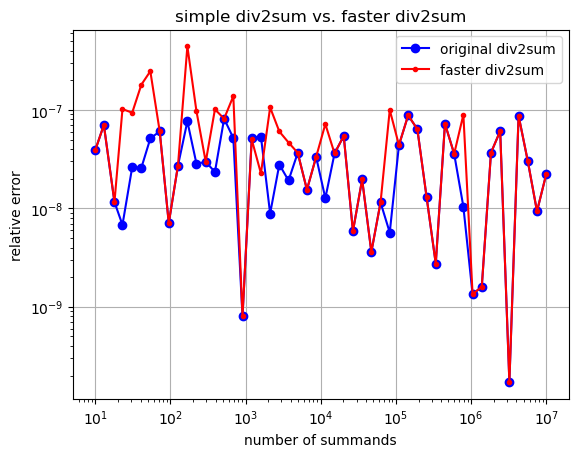

In [20]:
# Sum x[first:last].  This function works, but is a little slower than we would like.
function div2sum(x, first=firstindex(x), last=lastindex(x))
    n = last - first + 1;
    if n < 2
        s = zero(eltype(x))
        for i = first:last
            s += x[i]
        end
        return s
    else
        mid = (first + last) ÷ 2 # find middle as (first+last)/2, rounding down
        return div2sum(x, first, mid) + div2sum(x, mid+1, last)
    end
end

# Make it faster by enlarging the base case:
function div2sum_faster(x, first=firstindex(x), last=lastindex(x))
    n = last - first + 1;
    if n < 200
        s = zero(eltype(x))
        for i = first:last
            s += x[i]
        end
        return s
    else
        mid = (first + last) ÷ 2 # find middle as (first+last)/2, rounding down
        return div2sum_faster(x, first, mid) + div2sum_faster(x, mid+1, last)
    end
end

# check its accuracy for a set logarithmically spaced n's.  Since div2sum is slow,
# we won't go to very large n or use too many points
N = round.(Int, 10 .^ range(1,7,length=50)) # 50 points from 10¹ to 10⁷
err = Float64[]
err_faster = Float64[]
for n in N
    x = rand(Float32, n)
    xdouble = Float64.(x)
    push!(err, abs(div2sum(x) - sum(xdouble)) / abs(sum(xdouble)))
    push!(err_faster, abs(div2sum_faster(x) - sum(xdouble)) / abs(sum(xdouble)))
end

using PyPlot
loglog(N, err, "bo-")
loglog(N, err_faster, "r.-")
title("simple div2sum vs. faster div2sum")
xlabel("number of summands")
ylabel("relative error")
legend(["original div2sum", "faster div2sum"])
grid()

As we can see, the modified version has about the same accuracy.  But is it really faster?

Time it vs. the built-in `sum` (which is also written in Julia), and also write our own looping sum just so that we know exactly what it is doing:

In [21]:
function loopsum(x)
    s = zero(eltype(x))
    for i in eachindex(x)
        s += x[i]
    end
    return s
end

x = rand(Float32, 10^7)
using BenchmarkTools # better benchmarking utilities
@btime div2sum($x)
@btime div2sum_faster($x)
@btime sum($x)
@btime loopsum($x)

  23.769 ms (0 allocations: 0 bytes)
  3.661 ms (0 allocations: 0 bytes)
  1.123 ms (0 allocations: 0 bytes)
  3.971 ms (0 allocations: 0 bytes)


4.999777f6

Enlarging the base case made it more than **five times faster** and comparable in speed to `loopsum`, a naive loop.

The built-in `sum` function is still about 5 times faster.   It is actually using a [pairwise algorithm too, written in Julia](https://github.com/JuliaLang/julia/blob/38b3c46b0423ab1862f6cee7895a44e3ec397502/base/reduce.jl#L104-L113), but it plays some tricks with the base case to get better CPU utilization.  In particular, it uses [SIMD instructions in either native Julia code](https://github.com/JuliaLang/julia/pull/6928) or via the BLAS `asum` function, depending on the array type.   **Getting the last factor of 2 in performance is often tricky (and sometimes extremely hard)** and involves extracting every ounce of efficiency from the CPU with low-level tricks.

In this case, it turns out we can mostly catch up with the built-in `sum` just by adding a couple of decorations that turn on [SIMD optimization](http://kristofferc.github.io/post/intrinsics/) (`@simd`) and turn off bounds checking (`@inbounds`):

In [22]:
# Make it faster by enlarging the base case:
function div2sum_evenfaster(x, first=firstindex(x), last=lastindex(x))
    n = last - first + 1;
    if n < 200
        s = zero(eltype(x))
        @simd for i = first:last
            @inbounds s += x[i]
        end
        return s
    else
        mid = (first + last) ÷ 2 # find middle as (first+last)/2, rounding down
        return div2sum_evenfaster(x, first, mid) + div2sum_evenfaster(x, mid+1, last)
    end
end

@btime div2sum_evenfaster($x)

  1.842 ms (0 allocations: 0 bytes)


4.999763f6

We are now a lot closer to the 2.3ms of the built-in `sum` function.  (We can do a bit better by tuning the base-case size and other tricks.)